# Image Classification Using CNNs
This notebook contains two practise problems of image recognition. This is written following lesson 1 of fast.ai (http://course.fast.ai/lessons/lesson1.html), and study group material provided by Narayana Swamy (https://github.com/dlnerds/dlnerds) and David Morton (https://github.com/davidlmorton/fastai-course-sconce).

In [0]:
#!ps ax | grep python
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np

Clone to git repository and install Pytorch

In [34]:
!git clone https://github.com/amilacsw/fastai_course_amila.git

Cloning into 'fastai_course_amila'...
remote: Counting objects: 20, done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 1), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [14]:
#@title Import PyTorch modules if they are not present
!pip3 install torch torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

In [0]:
#import sys
#sys.path.append('fastai-course-amila/dllib/')
#import dllib
from fastai_course_amila.dllib import train as train
from fastai_course_amila.dllib.utils import plot_confusion_matrix as plot_confusion_matrix
from fastai_course_amila.dllib import lr_sched as lr_sched
plt.ion()   # interactive mode

## Mount Google Drive to get data

Use `mount_GoogleDrive.ipynb` to mount your google drive. Make sure you upload your training and validation images to a folder in your google drive.

In [42]:
!ls

data	 dlnerds  fastai_course_amila  hymenoptera_data.zip
datalab  drive	  fastai-course-amila


In [0]:
# copy data to data/ directory
!cp drive/NN_training_data/HollywoodVsBollywood.zip data/
!unzip data/HollywoodVsBollywood.zip -d data/
!ls data/

In [45]:
!ls data/HollywoodVsBollywood/

train  val


In [0]:
# set PATH to this data directory
PATH = 'data/HollywoodVsBollywood/'
sz = 224 # we start with size 224 because RESNET is trained on that value. This way, it will be easier to find minima

## Transforms
[See all the different pre-defined Transformsof Pytorch here.](http://pytorch.org/docs/master/torchvision/transforms.html)  Data augmentation and normalization for training. The normalization parameters come from the Imagenet data. We can try other types of transformations. The Crop(224) is there to bring all the images to 224 x 224 size. This is the size of the Imagenet pictures. Just normalization for validation. The Transformations won't change the original data, just applies the transforms to the dat before it is used in the training loop.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Let's see how one of these transforms work.

In [0]:
test1 = transforms.RandomHorizontalFlip()

In [0]:
from PIL import Image
img = Image.open('data/HollywoodVsBollywood/val/hollywood/091610-Faster.jpg.jpeg')

In [0]:
plt.imshow(img)

In [0]:
files = !ls {PATH}val/hollywood | head

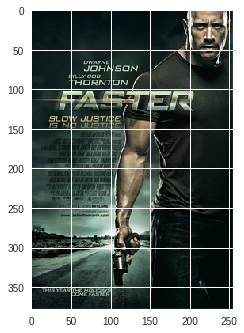

In [20]:
img = plt.imread(f'{PATH}/val/hollywood/{files[5]}')
plt.imshow(img)

In [0]:
crop_image = test1(img)

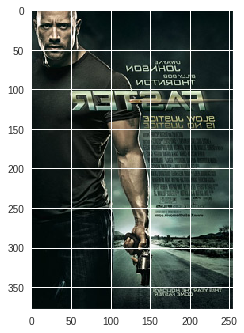

In [26]:
plt.imshow(crop_image)

We hope the neural network would learn to identify the difference between letters. Therefore, we don't need the horizontal flip.

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Load Data

In [0]:
image_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=15,
                                             shuffle=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

#check if GPU is available
use_gpu = torch.cuda.is_available()

Take a look at our data

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

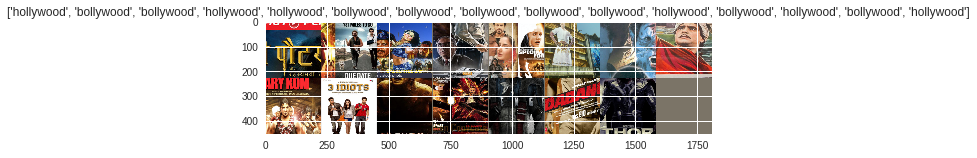

In [31]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model using a pre-trained Resnet model
We are not going to train any of the weights of the pre-trained model except for the last fully connected layer. Imagenet model has 1000 classes. The Resnet model was trained on the imagenet data. We are going to replace the last fully connected unit with 2 classes and train that last unit to recognize the hollywood vs bollywood posters. We expect a lower accuracy here because these two classes do not correspond to any two distinct classes found in Imagenet data.

In [32]:
base_model = torchvision.models.resnet18(pretrained=True)
for param in base_model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /content/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 24302317.90it/s]


In [33]:
base_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)

In [0]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return x
    
    def calculate_loss(self, outputs, targets, **kwargs):
        return F.nll_loss(input=outputs, target=targets)

    def calculate_metrics(self, outputs, targets, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return classification_accuracy

In [0]:
model_conv = MyModel(base_model)

if torch.cuda.is_available():
    model_conv.cuda()

In [37]:
model_conv

MyModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [0]:
from fastai_course_amila.dllib.model import model_summary

## Our first model
Now that we've seen the structures of the models above, let's make a new class and a function to do all the model related stuff above at one place.

In [0]:
class MyModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        
    def forward(self, inputs, **kwargs):
        x = self.base_model(inputs)
        x = F.log_softmax(x, dim=1)
        return x
    
    def calculate_loss(self, outputs, targets, **kwargs):
        return F.nll_loss(input=outputs, target=targets)

    def calculate_metrics(self, outputs, targets, **kwargs):
        y_out = np.argmax(outputs.cpu().data.numpy(), axis=1)
        y_in = targets.cpu().data.numpy()
        num_correct = (y_out - y_in == 0).sum()
        classification_accuracy = num_correct / len(y_in)
        return classification_accuracy
      
      
def create_model():
    # Get a resnet model pretrained on imagenet data (will download training weights).
    base_model = torchvision.models.resnet18(pretrained=True)
    
    # Freeze all layers, so they don't get updated during training.
    for param in base_model.parameters():
        param.requires_grad = False
        
    # Replace last fully-connected layer with one that outputs only two categories (cat / dog).
    # This is now the only layer that isn't yet trained.
    base_model.fc = nn.Linear(in_features=base_model.fc.in_features, out_features=2)
    return MyModel(base_model)

In [0]:
model_conv = MyModel(base_model)

if torch.cuda.is_available():
    model_conv.cuda()

## Construct Trainer

In [0]:
# Observe that only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_conv.base_model.fc.parameters(), lr=0.001, momentum=0.9)

# Trainer
train_conv = train.Trainer(model_conv,dataloaders['train'],dataloaders['val'],optimizer_conv)

## Survey for a learning rate

  0%|          | 0/37 [00:00<?, ?it/s]

Trying learning rates between 1e-05 and 10 over 37 steps (1 epochs)
Epoch 0/0
----------


  3%|▎         | 1/37 [00:02<01:21,  2.27s/it]

Iteration No:1 Learn rate 1.00E-05 Batch Loss: 0.9574 Batch Accuracy: 0.5333 


  5%|▌         | 2/37 [00:04<01:15,  2.15s/it]

Iteration No:2 Learn rate 1.45E-05 Batch Loss: 0.8065 Batch Accuracy: 0.6000 


  8%|▊         | 3/37 [00:06<01:12,  2.14s/it]

Iteration No:3 Learn rate 2.11E-05 Batch Loss: 0.8033 Batch Accuracy: 0.5333 


 11%|█         | 4/37 [00:08<01:10,  2.12s/it]

Iteration No:4 Learn rate 3.07E-05 Batch Loss: 0.7528 Batch Accuracy: 0.6000 


 14%|█▎        | 5/37 [00:10<01:08,  2.14s/it]

Iteration No:5 Learn rate 4.45E-05 Batch Loss: 0.9260 Batch Accuracy: 0.4667 


 16%|█▌        | 6/37 [00:12<01:06,  2.15s/it]

Iteration No:6 Learn rate 6.47E-05 Batch Loss: 0.8481 Batch Accuracy: 0.6000 


 19%|█▉        | 7/37 [00:14<01:04,  2.14s/it]

Iteration No:7 Learn rate 9.40E-05 Batch Loss: 0.9410 Batch Accuracy: 0.4000 


 22%|██▏       | 8/37 [00:17<01:02,  2.16s/it]

Iteration No:8 Learn rate 1.37E-04 Batch Loss: 0.8827 Batch Accuracy: 0.5333 


 24%|██▍       | 9/37 [00:19<01:00,  2.18s/it]

Iteration No:9 Learn rate 1.98E-04 Batch Loss: 0.6840 Batch Accuracy: 0.6000 


 27%|██▋       | 10/37 [00:21<00:58,  2.16s/it]

Iteration No:10 Learn rate 2.88E-04 Batch Loss: 0.6077 Batch Accuracy: 0.7333 


 30%|██▉       | 11/37 [00:23<00:55,  2.15s/it]

Iteration No:11 Learn rate 4.18E-04 Batch Loss: 0.6101 Batch Accuracy: 0.6667 


 32%|███▏      | 12/37 [00:25<00:53,  2.15s/it]

Iteration No:12 Learn rate 6.08E-04 Batch Loss: 0.5818 Batch Accuracy: 0.8000 


 35%|███▌      | 13/37 [00:28<00:52,  2.17s/it]

Iteration No:13 Learn rate 8.83E-04 Batch Loss: 0.8440 Batch Accuracy: 0.3333 


 38%|███▊      | 14/37 [00:30<00:50,  2.20s/it]

Iteration No:14 Learn rate 1.28E-03 Batch Loss: 0.6176 Batch Accuracy: 0.6667 


 41%|████      | 15/37 [00:33<00:48,  2.20s/it]

Iteration No:15 Learn rate 1.86E-03 Batch Loss: 1.0809 Batch Accuracy: 0.4667 


 43%|████▎     | 16/37 [00:35<00:46,  2.19s/it]

Iteration No:16 Learn rate 2.71E-03 Batch Loss: 1.2541 Batch Accuracy: 0.5333 


 46%|████▌     | 17/37 [00:37<00:44,  2.20s/it]

Iteration No:17 Learn rate 3.93E-03 Batch Loss: 0.8296 Batch Accuracy: 0.5333 


 49%|████▊     | 18/37 [00:39<00:41,  2.20s/it]

Iteration No:18 Learn rate 5.71E-03 Batch Loss: 0.5322 Batch Accuracy: 0.8667 


 51%|█████▏    | 19/37 [00:41<00:39,  2.19s/it]

Iteration No:19 Learn rate 8.30E-03 Batch Loss: 0.5973 Batch Accuracy: 0.6000 


 54%|█████▍    | 20/37 [00:43<00:37,  2.19s/it]

Iteration No:20 Learn rate 1.21E-02 Batch Loss: 0.4758 Batch Accuracy: 0.8000 


 57%|█████▋    | 21/37 [00:45<00:34,  2.18s/it]

Iteration No:21 Learn rate 1.75E-02 Batch Loss: 0.6002 Batch Accuracy: 0.6667 


 59%|█████▉    | 22/37 [00:48<00:33,  2.22s/it]

Iteration No:22 Learn rate 2.54E-02 Batch Loss: 1.3520 Batch Accuracy: 0.4667 


 62%|██████▏   | 23/37 [00:50<00:30,  2.21s/it]

Iteration No:23 Learn rate 3.69E-02 Batch Loss: 0.5430 Batch Accuracy: 0.8000 


 65%|██████▍   | 24/37 [00:53<00:28,  2.21s/it]

Iteration No:24 Learn rate 5.37E-02 Batch Loss: 1.7939 Batch Accuracy: 0.5333 


 68%|██████▊   | 25/37 [00:55<00:26,  2.22s/it]

Iteration No:25 Learn rate 7.80E-02 Batch Loss: 2.4938 Batch Accuracy: 0.5333 


 70%|███████   | 26/37 [00:58<00:24,  2.23s/it]

Iteration No:26 Learn rate 1.13E-01 Batch Loss: 1.2988 Batch Accuracy: 0.7333 


 73%|███████▎  | 27/37 [01:00<00:22,  2.24s/it]

Iteration No:27 Learn rate 1.65E-01 Batch Loss: 1.2604 Batch Accuracy: 0.8667 


 76%|███████▌  | 28/37 [01:02<00:20,  2.23s/it]

Iteration No:28 Learn rate 2.39E-01 Batch Loss: 6.9778 Batch Accuracy: 0.6000 


 78%|███████▊  | 29/37 [01:04<00:17,  2.22s/it]

Iteration No:29 Learn rate 3.47E-01 Batch Loss: 15.2244 Batch Accuracy: 0.4667 


 81%|████████  | 30/37 [01:06<00:15,  2.22s/it]

Iteration No:30 Learn rate 5.04E-01 Batch Loss: 42.8486 Batch Accuracy: 0.2000 


 84%|████████▍ | 31/37 [01:08<00:13,  2.22s/it]

Iteration No:31 Learn rate 7.33E-01 Batch Loss: 78.8815 Batch Accuracy: 0.4667 


 86%|████████▋ | 32/37 [01:10<00:11,  2.22s/it]

Iteration No:32 Learn rate 1.06E+00 Batch Loss: 55.6547 Batch Accuracy: 0.6000 


 89%|████████▉ | 33/37 [01:13<00:08,  2.22s/it]

Iteration No:33 Learn rate 1.55E+00 Batch Loss: 97.7134 Batch Accuracy: 0.4000 


 92%|█████████▏| 34/37 [01:15<00:06,  2.22s/it]

Iteration No:34 Learn rate 2.25E+00 Batch Loss: 47.4688 Batch Accuracy: 0.6667 


 95%|█████████▍| 35/37 [01:17<00:04,  2.21s/it]

Iteration No:35 Learn rate 3.26E+00 Batch Loss: 61.7266 Batch Accuracy: 0.6667 
Iteration No:36 Learn rate 4.74E+00 Batch Loss: 314.1427 Batch Accuracy: 0.4000 


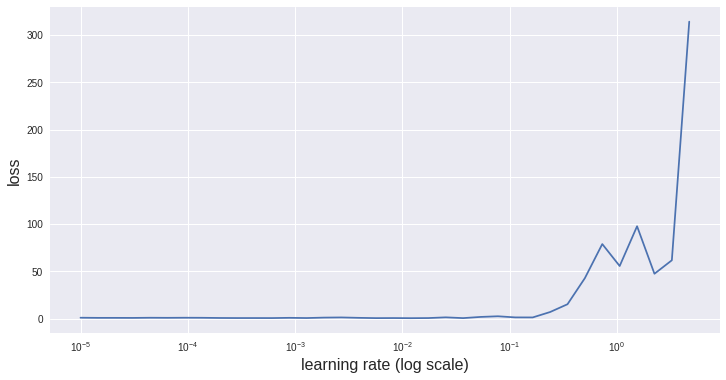

In [47]:
lrf = train_conv.lr_find()

In [48]:
train_conv.sched.plot_lr()

AttributeError: ignored

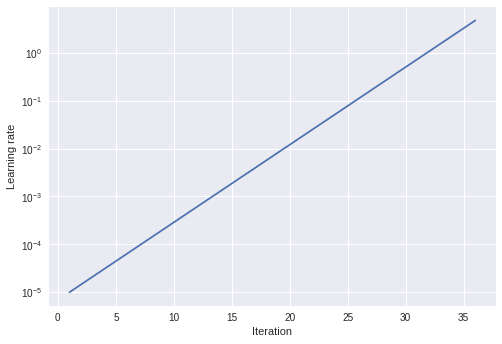

In [49]:
train_conv.plot_lr() # How do I make it to non-linearly increase?

## Train the model
Specify the number of epochs to train the model

  0%|          | 0/37 [00:00<?, ?it/s]

Epoch 0/1
----------


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss: 0.7298 Acc: 0.5670


  0%|          | 0/37 [00:00<?, ?it/s]

val Loss: 0.6093 Acc: 0.6779

Epoch 1/1
----------


  0%|          | 0/10 [00:00<?, ?it/s]

train Loss: 0.5291 Acc: 0.7391


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


val Loss: 0.5973 Acc: 0.6913

Training complete in 3m 31s
Best val Acc: 0.691275


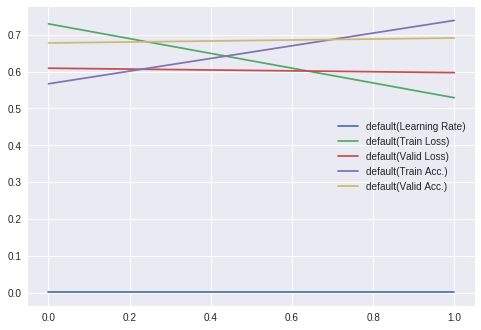

In [50]:
train_conv.train_model(num_epochs=2)

## Evaluate model predictions

100%|██████████| 10/10 [00:21<00:00,  2.16s/it]


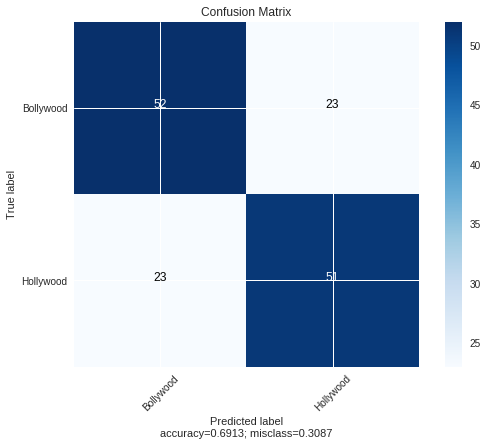

In [56]:
probs,target = train_conv.predict_with_targs()
preds = np.argmax(probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target, preds)
plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['Bollywood', 'Hollywood'],
                      title        = "Confusion Matrix")

In [54]:
target

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0])

In [55]:
preds

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [58]:
dir(train_conv)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_restore_state',
 '_save_state',
 '_saved_state',
 'best_acc',
 'best_model_wts',
 'best_optimizer_params',
 'criterion',
 'device',
 'evaluate_on_batch',
 'fit_on_batch',
 'history',
 'load_model',
 'loss_lr_plot',
 'lr_find',
 'model',
 'name',
 'optimizer',
 'plot_lr',
 'pre_trained',
 'predict',
 'predict_with_targs',
 'predict_with_targs_',
 'save_checkpoint',
 'save_model',
 'train_loader',
 'train_model',
 'val_loader']

In [0]:
??train_conv.predict_with_targs()

In [0]:
??torch.cat

In [0]:
??train_conv.val_loader